In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
from tqdm import tqdm
from numpy import linalg as LA
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [17]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [18]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [19]:
# train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
# train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

train_input = [RNA_s3d1]
train_output = [pro_s3d1]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d9]
test_output = [pro_s4d9]

In [20]:
train_input = train_input
train_output = train_output

In [21]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [22]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [23]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [24]:
train_input = torch.from_numpy(train_input)
val_input = torch.from_numpy(val_input)
test_input = torch.from_numpy(test_input)

train_output = torch.from_numpy(train_output)
val_output = torch.from_numpy(val_output)
test_output = torch.from_numpy(test_output)

In [25]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

torch.Size([8582, 13953])
torch.Size([28921, 13953])
torch.Size([459, 13953])
torch.Size([8582, 1])
torch.Size([28921, 1])
torch.Size([459, 1])


In [26]:
def top_samples(source, target, num):
    distances = LA.norm(source-target, axis=1)
    temp_list = []
    for i in range(len(distances)):
        temp_list.append([distances[i], i])
    temp_list.sort()
    return [ele[1] for ele in temp_list[:num]]

In [27]:
nn_num = 10

In [28]:
input_near_ind_list = []
output_near_ind_list = []

for i in tqdm(range(test_input.shape[0])):
    near_neig_ind = top_samples(test_input[i], train_input, nn_num)
    input_near_ind_list.append(train_input[near_neig_ind])
    output_near_ind_list.append(train_output[near_neig_ind])
    
input_near = np.concatenate(input_near_ind_list, axis= 0)
output_near = np.concatenate(output_near_ind_list, axis= 0)

100%|██████████| 459/459 [01:24<00:00,  5.42it/s]


In [29]:
def top_samples_distances(source, target, num):
    distances = LA.norm(source-target, axis=1)
    temp_list = []
    for i in range(len(distances)):
        temp_list.append([distances[i], i])
    temp_list.sort()
    return sum([ele[0] for ele in temp_list[:num]])

In [30]:
# train_batches = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5, RNA_s3d1, RNA_s3d6, RNA_s3d7, RNA_s4d1, RNA_s4d8, RNA_s4d9]
# train_batches_names = ['RNA_s1d1', 'RNA_s1d2', 'RNA_s1d3', 'RNA_s2d1', 'RNA_s2d4', 'RNA_s2d5', 'RNA_s3d1', 'RNA_s3d6', 'RNA_s3d7', 'RNA_s4d1', 'RNA_s4d8', 'RNA_s4d9']

# for j in range(len(train_batches)):
#     dis_sum = 0
#     for i in range(RNA_s4d9.shape[0]):
#         near_dis_sum = top_samples_distances(RNA_s4d9[i], train_batches[j], nn_num)
#         dis_sum = dis_sum + near_dis_sum
#     print('batch:', train_batches_names[j], 'distance sum:', dis_sum)

In [31]:
# with open(r"input_near_eucli.pickle", "wb") as output_file:
#     pickle.dump(input_near, output_file)
    
# with open(r"output_near_eucli.pickle", "wb") as output_file:
#     pickle.dump(output_near, output_file)

In [32]:
# with open(r"input_near_eucli.pickle", "rb") as input_file:
#     input_near = pickle.load(input_file)
    
# with open(r"output_near_eucli.pickle", "rb") as input_file:
#     output_near = pickle.load(input_file)

In [33]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [34]:
train_input = train_input.float()
val_input = val_input.float()
test_input = test_input.float()

train_output = train_output.float()
val_output = val_output.float()
test_output = test_output.float()

In [35]:
# input_near = input_near.float()
# output_near = output_near.float()

In [36]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [37]:
train_input = train_input.to(device)
val_input = val_input.to(device)
test_input = test_input.to(device)

train_output = train_output.to(device)
val_output = val_output.to(device)
test_output = test_output.to(device)

In [38]:
# input_near = torch.from_numpy(input_near)
# output_near = torch.from_numpy(output_near)

In [39]:
input_near = torch.from_numpy(input_near)
output_near = torch.from_numpy(output_near)

input_near = input_near.to(device)
output_near = output_near.to(device)

In [40]:
input_feature = RNA_s1d1.shape[1]

In [41]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [42]:
PATH = 'No_norm_model_RNA_pro'

In [43]:
def fit(num_epochs, model, loss_fn, RNA, pro):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            near_pred = model(input_near)
            near_loss = loss_fn(near_pred, output_near)
            near_loss = torch.sqrt(near_loss)
            near_loss = near_loss.cpu().detach().numpy()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
            test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            
            print('Epoch ', epoch, 'near loss:', near_loss, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:',
                  s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss, 'test loss:', test_loss)
            
        if epoch % 1000 == 0:
            figure, ax = plt.subplots(1, 13, figsize = (33, 3))
            for i in range(1):
                
                ax[0].scatter(output_near.cpu().detach().numpy()[:, 0], near_pred.cpu().detach().numpy()[:, 0], c='purple', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Nearest neighbor result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')
                
                ax[1].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d1 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d2 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')

                ax[3].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s1d3 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')
                
                ax[4].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d1 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d4 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')

                ax[6].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s2d5 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')
                
                ax[7].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d1 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d6 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')

                ax[9].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s3d7 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')
                
                ax[10].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d1 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d8 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')

                ax[12].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[12].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[12].set_title('s4d9 result')
                ax[12].set_xlabel('true')
                ax[12].set_ylabel('pred')
            
            plt.show()
    return

Epoch  0 near loss: 0.42946163 s1d1:  1.1805438 s1d2:  1.2749149 s1d3:  1.1305217 s2d1: 0.5576821 s2d4: 0.7442891 s2d5: 0.8022247 s3d1: 0.32388586 s3d6: 0.8045592 s3d7: 0.9315638 s4d1: 0.966497 s4d8: 1.1973971 s4d9: 0.53590417 test loss: 0.8605840434611582


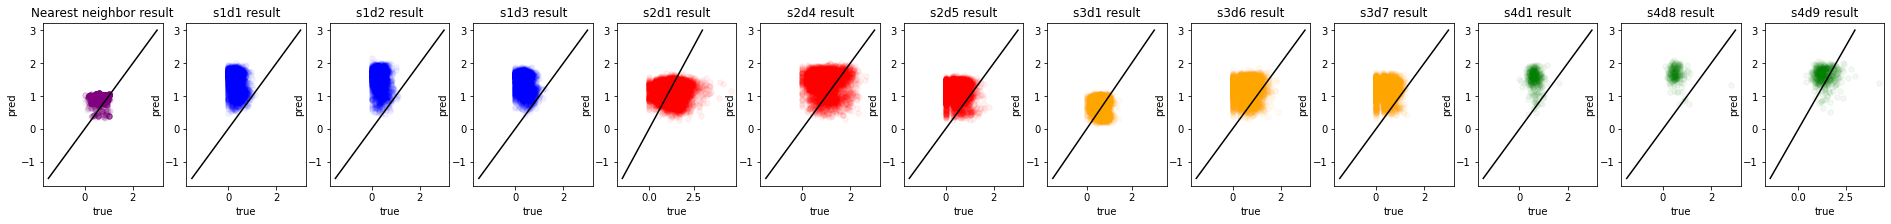

Epoch  100 near loss: 0.07728378 s1d1:  0.6501101 s1d2:  0.63337564 s1d3:  0.5966634 s2d1: 0.6928367 s2d4: 0.45974052 s2d5: 0.3875018 s3d1: 0.20254207 s3d6: 0.40102363 s3d7: 0.44590303 s4d1: 0.38713264 s4d8: 0.56111264 s4d9: 0.5370008 test loss: 0.49758648292013413
Epoch  200 near loss: 0.047372747 s1d1:  0.6525025 s1d2:  0.64191353 s1d3:  0.5978137 s2d1: 0.686965 s2d4: 0.4642742 s2d5: 0.39809048 s3d1: 0.2020085 s3d6: 0.42091677 s3d7: 0.4607538 s4d1: 0.39711353 s4d8: 0.5843479 s4d9: 0.5227396 test loss: 0.49877757297989117
Epoch  300 near loss: 0.033383623 s1d1:  0.6468343 s1d2:  0.63551015 s1d3:  0.593234 s2d1: 0.6856579 s2d4: 0.46631473 s2d5: 0.4013807 s3d1: 0.20268884 s3d6: 0.4269569 s3d7: 0.4629971 s4d1: 0.39471838 s4d8: 0.5836852 s4d9: 0.52085936 test loss: 0.49707618760869426
Epoch  400 near loss: 0.025655836 s1d1:  0.6464921 s1d2:  0.63539606 s1d3:  0.59316516 s2d1: 0.6827709 s2d4: 0.46717107 s2d5: 0.40545517 s3d1: 0.20251197 s3d6: 0.4319622 s3d7: 0.46821457 s4d1: 0.39624682 s4d

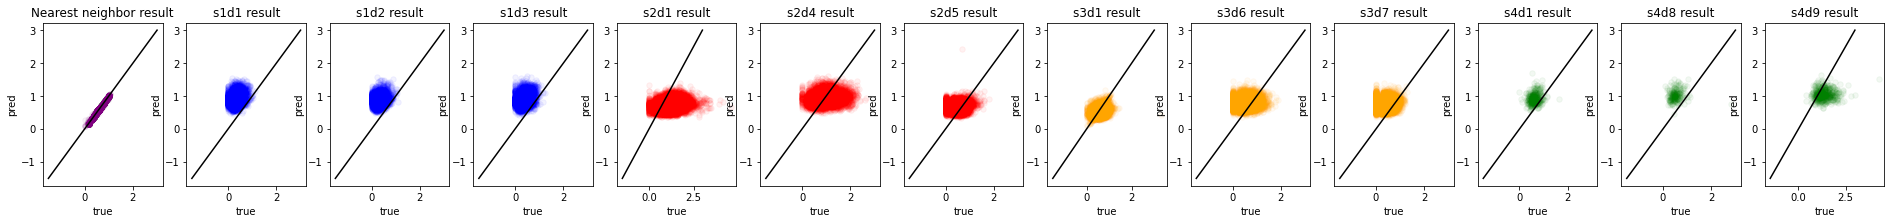

Epoch  1100 near loss: 0.008858447 s1d1:  0.63085186 s1d2:  0.6230777 s1d3:  0.57529473 s2d1: 0.68356496 s2d4: 0.46809068 s2d5: 0.40752673 s3d1: 0.20173311 s3d6: 0.43445286 s3d7: 0.47499648 s4d1: 0.38805285 s4d8: 0.5757776 s4d9: 0.5219538 test loss: 0.4939311955049741
Epoch  1200 near loss: 0.008043749 s1d1:  0.6267686 s1d2:  0.6194442 s1d3:  0.5710586 s2d1: 0.68475497 s2d4: 0.4680818 s2d5: 0.4066095 s3d1: 0.20163564 s3d6: 0.43316495 s3d7: 0.4738038 s4d1: 0.38484448 s4d8: 0.5720978 s4d9: 0.52423936 test loss: 0.49331831672875515
Epoch  1300 near loss: 0.007415235 s1d1:  0.6230841 s1d2:  0.61595774 s1d3:  0.56726146 s2d1: 0.68603337 s2d4: 0.4681085 s2d5: 0.40557414 s3d1: 0.20159042 s3d6: 0.43184918 s3d7: 0.47252244 s4d1: 0.38181424 s4d8: 0.56871563 s4d9: 0.52617306 test loss: 0.49266687375684504
Epoch  1400 near loss: 0.006836285 s1d1:  0.62365574 s1d2:  0.6162047 s1d3:  0.5678409 s2d1: 0.68493706 s2d4: 0.46823972 s2d5: 0.40635857 s3d1: 0.20139456 s3d6: 0.4328826 s3d7: 0.47384346 s4d1: 

KeyboardInterrupt: 

In [44]:
num_epochs = 2000
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, input_near, output_near)